![image.png](https://i.imgur.com/a3uAqnb.png)

# Image Classification using CNN: CIFAR10
- **Images**: 60,000 color images of size **(32x32)** in **10 categories**, with 6000 images per class. There are 50000 training images and 10000 test images.
- **Classes**: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.
- **Shape**: `(batch_size, 3, 32, 32)` → 3 channels (RGB).
  
![CIFAR-10 image](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)


## 1️⃣ Dataset Class

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Define transformations (convert to tensor)                         ## Will study in-depth in a next lab
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root="./data", train=True, transform=transform, download=True)
#######################
#When loading an already existing dataset, we use the transforms directly in the beginning...
#######################
test_dataset = CIFAR10(root="./data", train=False, transform=transform, download=True)

# Create DataLoaders
# (The Dataset Class loads only one sample at a time. We pass it to dataloader to read batch_size of images at a time)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check dataset size
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


Training samples: 50000, Testing samples: 10000


### Let's display some images

Question: So the train loader has batches, and the iter is used to load the first batch and save it in data_iter?


Exactly ✅

Here’s a step-by-step explanation:

✔️ train_loader (PyTorch DataLoader)
Think of it like a list of batches.

Each batch contains a tuple: (images, labels)

images: a tensor of shape (batch_size, 3, 32, 32) (CIFAR-10 format)

labels: a tensor of shape (batch_size,)

✔️ iter(train_loader)

data_iter = iter(train_loader)
Converts the train_loader into an iterator.

Now, instead of looping through it with a for loop, you can manually grab batches using next().

✔️ next(data_iter)

images, labels = next(data_iter)
Fetches the first batch from the iterator.

Stores the batch of images and corresponding labels into the variables images and labels.

🔁 Why use iter(...) and next(...) manually?
You could also use:


for images, labels in train_loader:
    break
But using iter(...) and next(...) directly gives more control, especially when you only want one batch, like for visualizing or debugging.

So yes — your understanding is correct:

"The train loader has batches, and the iter is used to load the first batch and save it in data_iter?"
✅ Yes — and then you use next(data_iter) to grab that first batch.

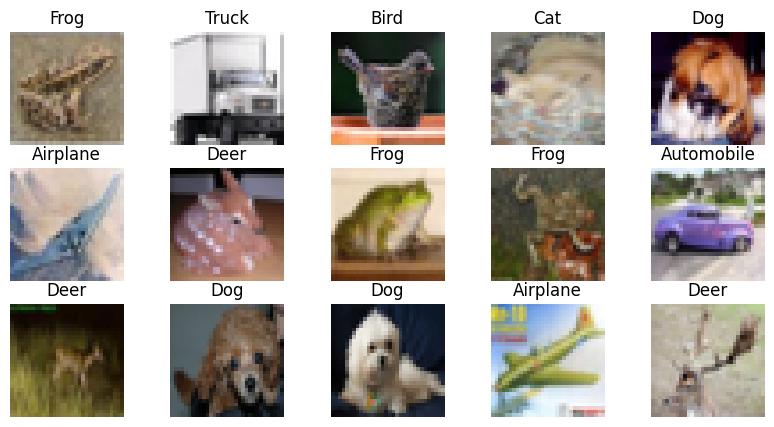

Shape of one image tensor: torch.Size([3, 32, 32])


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
data_iter = iter(train_loader) #Converts the train_loader into an iterator.
images, labels = next(data_iter) # Fetches the first batch from the iterator.

# CIFAR-10 class names
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Show images
fig, axes = plt.subplots(3, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = images[i]
    img = np.transpose(img.numpy(), (1, 2, 0))  # Convert (C, H, W) to (H, W, C)

    ax.imshow(img)
    ax.set_title(classes[labels[i].item()])
    ax.axis("off")

plt.show()

# Show shape of one image
print("Shape of one image tensor:", images[0].shape)  # Expected: (3, 32, 32)


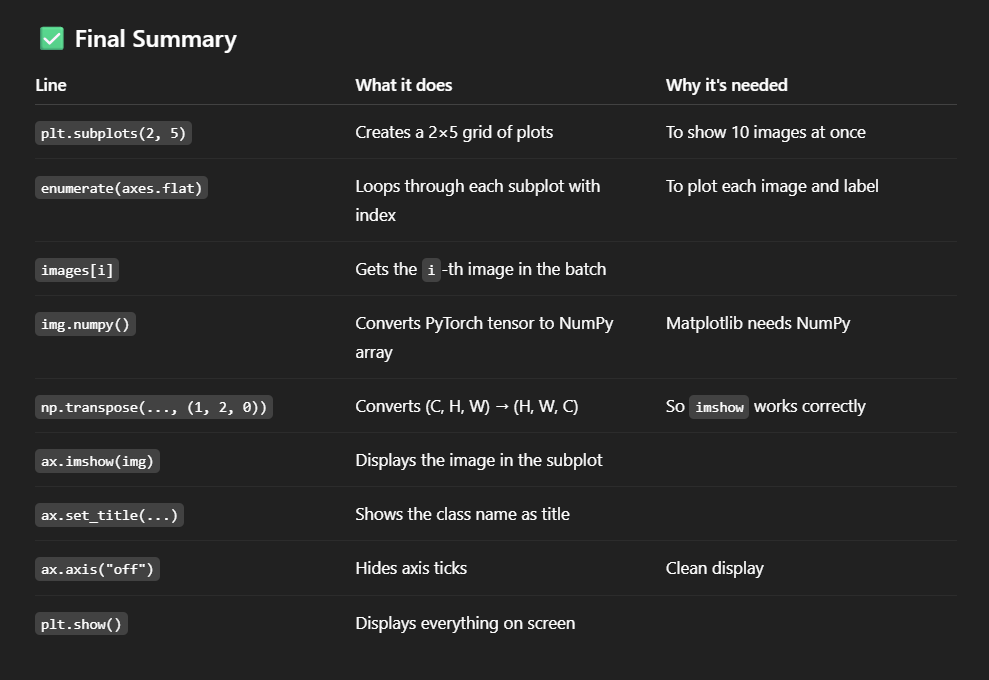

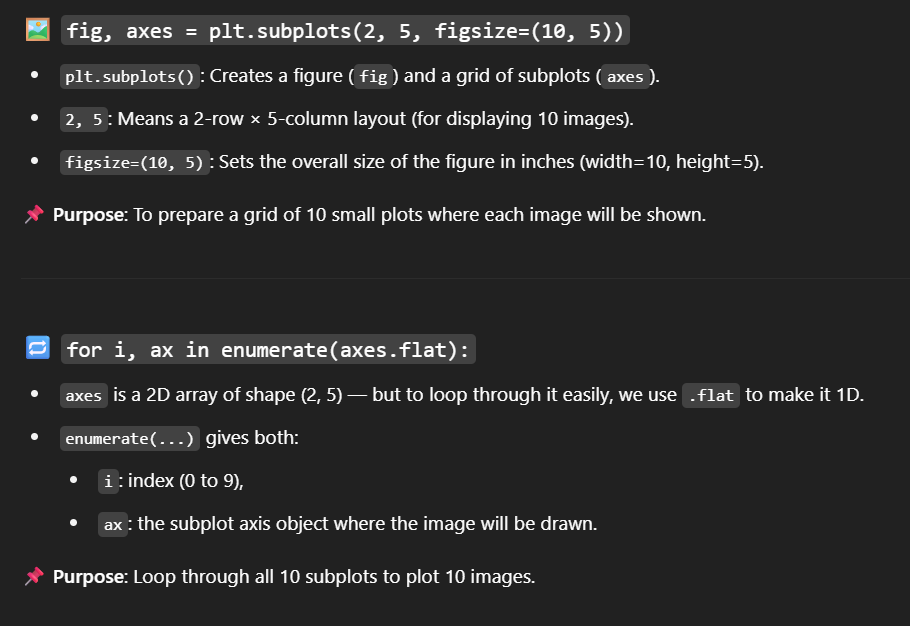

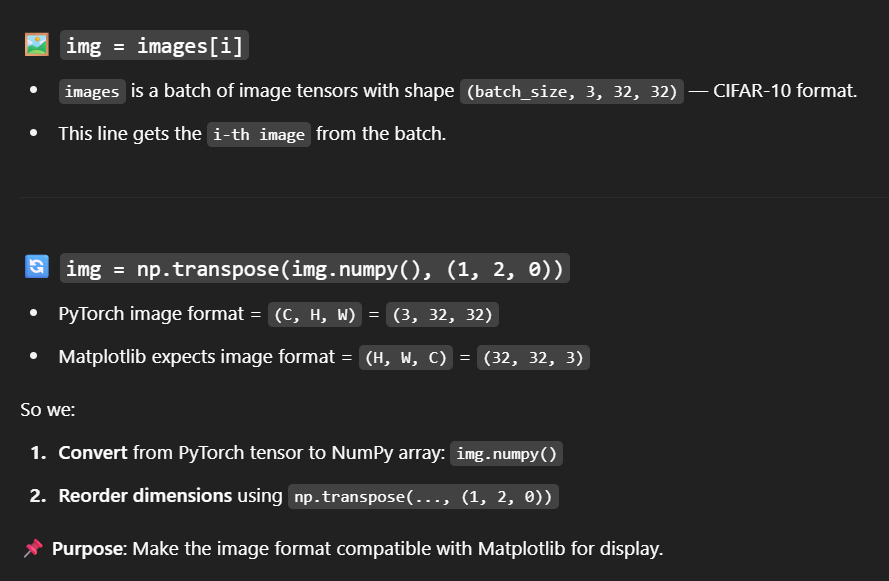

## 2️⃣ Model Class

In [4]:
import torch.nn as nn
import torch

# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Activation
        self.relu = nn.ReLU()

        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for CIFAR-10

    def forward(self, x):
        # Convolution + ReLU + Pooling
        x = self.pool(self.relu(self.conv1(x)))  # (Batch, 16, 16, 16)
        x = self.pool(self.relu(self.conv2(x)))  # (Batch, 32, 8, 8)
        x = self.pool(self.relu(self.conv3(x)))  # (Batch, 64, 4, 4)

        # Flatten
        x = x.view(x.size(0), -1)  # (Batch, 64*4*4)

        # Fully Connected Layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Logits

        return x                # Although this is a classification problem, we didn't apply softmax. Do you know why?👀 (Hint: CrossEntropyLoss has something to do here👀)

## 3️⃣ Training and Validation Loops

In [5]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Track accuracy
        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_loss += loss.item()

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy


## 4️⃣ Running Training

In [6]:
import torch.optim as optim

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 1563/1563 [00:12<00:00, 121.08it/s]


Epoch 1/10: Train Loss=1.5562, Train Accuracy=43.30%, Val Loss=1.3443, Val Accuracy=51.25%


100%|██████████| 1563/1563 [00:12<00:00, 128.83it/s]


Epoch 2/10: Train Loss=1.1562, Train Accuracy=58.84%, Val Loss=1.0602, Val Accuracy=61.94%


100%|██████████| 1563/1563 [00:11<00:00, 134.34it/s]


Epoch 3/10: Train Loss=0.9891, Train Accuracy=65.26%, Val Loss=1.0091, Val Accuracy=64.17%


100%|██████████| 1563/1563 [00:11<00:00, 131.10it/s]


Epoch 4/10: Train Loss=0.8853, Train Accuracy=69.14%, Val Loss=0.9365, Val Accuracy=67.11%


100%|██████████| 1563/1563 [00:12<00:00, 129.79it/s]


Epoch 5/10: Train Loss=0.8065, Train Accuracy=71.67%, Val Loss=0.8816, Val Accuracy=69.15%


100%|██████████| 1563/1563 [00:12<00:00, 128.58it/s]


Epoch 6/10: Train Loss=0.7485, Train Accuracy=73.63%, Val Loss=0.8376, Val Accuracy=71.32%


100%|██████████| 1563/1563 [00:12<00:00, 125.71it/s]


Epoch 7/10: Train Loss=0.6892, Train Accuracy=75.92%, Val Loss=0.8489, Val Accuracy=71.04%


100%|██████████| 1563/1563 [00:12<00:00, 129.58it/s]


Epoch 8/10: Train Loss=0.6457, Train Accuracy=77.25%, Val Loss=0.9158, Val Accuracy=69.19%


100%|██████████| 1563/1563 [00:12<00:00, 126.32it/s]


Epoch 9/10: Train Loss=0.6061, Train Accuracy=78.53%, Val Loss=0.8417, Val Accuracy=71.70%


100%|██████████| 1563/1563 [00:12<00:00, 128.40it/s]


Epoch 10/10: Train Loss=0.5624, Train Accuracy=80.07%, Val Loss=0.9080, Val Accuracy=70.18%


### Plot loss and some predictions

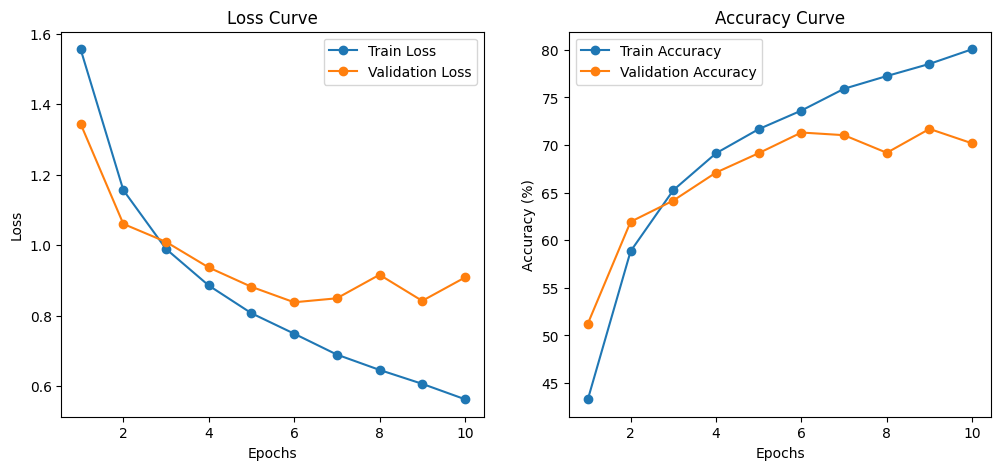

In [7]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


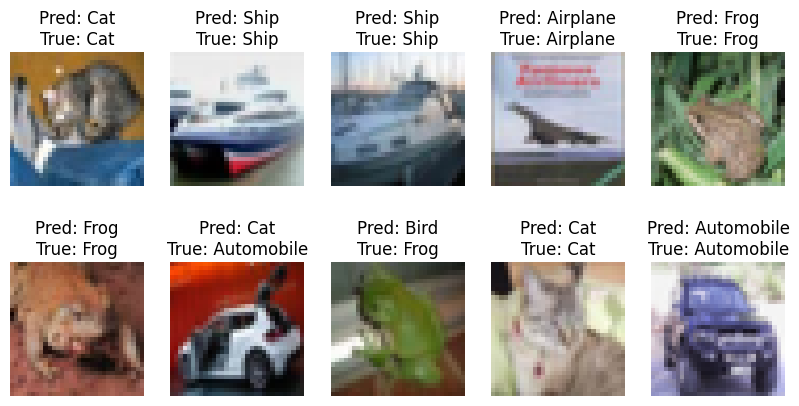

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images with predicted labels
def show_predictions(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode
    images, labels = next(iter(dataloader))  # Get a batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(images)
        predictions = outputs.argmax(dim=1)  # Get predicted class

    # CIFAR-10 class names
    classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    # Plot images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    for i, ax in enumerate(axes.flat[:num_images]):
        img = images[i]
        img = np.transpose(img.cpu().numpy(), (1, 2, 0))  # Convert to (H, W, C)

        ax.imshow(img)
        ax.set_title(f"Pred: {classes[predictions[i].item()]}\nTrue: {classes[labels[i].item()]}")
        ax.axis("off")

    plt.show()

# Show predictions
show_predictions(model, test_loader, device)


### Contributed by: Mohamed Eltayeb

![image.png](https://i.imgur.com/a3uAqnb.png)